In [1]:
import numpy as np
import os 
os.chdir('C:\\Users\\Windows1998\\Desktop\\Deepfake')

In [1]:
import tqdm.notebook as tq
import numpy as np
import os
from PIL import Image

In [3]:
X = np.load('X_64.npy')
y = np.load('y_64.npy')

In [4]:
X.shape, y.shape

((78211, 64, 64, 3), (78211,))

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape,X_val.shape, y_val.shape

((38322, 64, 64, 3),
 (23464, 64, 64, 3),
 (38322,),
 (23464,),
 (16425, 64, 64, 3),
 (16425,))

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

Matplotlib is building the font cache; this may take a moment.


device(type='cuda', index=0)

In [9]:
import joblib
import pickle
import pandas as pd 
import copy
import skimage.transform
from torch import topk
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
from sklearn.metrics import classification_report

In [10]:
# confusion matrix code 
import itertools
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
def confusion_matrix2(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7), path=None, filename=None):
        """
        cm: confusion matrix to be plotted.
        classes: array of labels or class names.
        title: title of the confusion matrix.
        cmap: color of the plot matrix.
        figsize: tupple (width, height) representiong size of the plot.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        
        # Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        cm = cm.astype(np.int64)
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
        if path:
            if filename is None:
                plt.savefig(os.path.join(path, title + '.png'))
            else:
                plt.savefig(os.path.join(path, filename + '.png'))
        plt.show()

In [1]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9370850944667547469
]


In [12]:
# data transform to size 64*64
data_transforms2 = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [13]:
#Class MyDataset to generate the transformed dataset
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        x = Image.fromarray(x).convert('RGB')
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

    def get_transformed(self):
      self.data2 = []
      for x in self.data:
        x = Image.fromarray(x)
        self.data2.append(self.transform(x))
      return torch.from_numpy(np.array(self.data2)).float()


# dataset 
train_dataset2 = MyDataset(X_train, y_train, data_transforms2['train'])
val_dataset2 = MyDataset(X_val,y_val,data_transforms2['val'])
test_dataset2 = MyDataset(X_test,y_test,data_transforms2['test'])

In [14]:
torch.manual_seed(42)

# loaders for images of size 64*64
train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True)
valid_loader2 = DataLoader(val_dataset2, batch_size=32, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False)

In [15]:
#for 64x64
dataloaders_2 = {}
dataloaders_2['train'] = train_loader2
dataloaders_2['test'] = test_loader2

In [16]:
def train_model(train_loader, test_loader, model, criterion, optimizer, epochs, save_path):
    start_time = datetime.now()
    valid_loss_min = np.Inf 
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        
        ##########
        #TRAINING 
        ##########
        model.train()
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # steps += 1
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            y_pred = model(inputs)
            loss = criterion(y_pred, labels)

            loss.backward()
            optimizer.step()

            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # running_loss += loss.item()


        ##########
        #VALIDATION 
        ##########
        model.eval()
        for batch_idx, (inputs, labels)  in enumerate(test_loader):

            inputs, labels = inputs.to(device), labels.to(device)

            y_val = model(inputs)
            loss =  criterion(y_val, labels)

            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

       # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        train_losses.append(train_loss)
        val_losses.append(valid_loss)
        
        if valid_loss < valid_loss_min:
            print('Saving model..')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
    
    # return trained model
    return model, train_losses, val_losses

In [33]:
# For 64x64 
class CNN_model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=6*6*32, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.out = nn.Linear(in_features=256, out_features=2)
        
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        # print(x.size())
        x = F.max_pool2d(x, kernel_size=2)
        # print(x.size())
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2)
        # print(x.size())
        x = x.view(-1, 6*6*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        # x = F.sigmoid(x, p=0.2)
        return self.out(x)

torch.manual_seed(42)

model_1 = CNN_model_1()
model_1.to(device)
model_1

CNN_model_1(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
#VARIATION 1

In [34]:
from torch import nn, optim
criterion= nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

In [35]:
CNN_model_1_64 , train_losses_cnn_1, val_losses_cnn_1 = train_model(
    train_loader=train_loader2,
    test_loader=valid_loader2,
    model=model_1,
    criterion=criterion,
    optimizer=optimizer,
    epochs=20, save_path = 'CNN_Model_1_64' 
)

Epoch: 0 	Training Loss: 0.453100 	Validation Loss: 0.326159
Saving model..
Epoch: 1 	Training Loss: 0.289158 	Validation Loss: 0.263686
Saving model..
Epoch: 2 	Training Loss: 0.237807 	Validation Loss: 0.214193
Saving model..
Epoch: 3 	Training Loss: 0.200681 	Validation Loss: 0.230750
Epoch: 4 	Training Loss: 0.178064 	Validation Loss: 0.183908
Saving model..
Epoch: 5 	Training Loss: 0.159887 	Validation Loss: 0.173827
Saving model..
Epoch: 6 	Training Loss: 0.142947 	Validation Loss: 0.199269
Epoch: 7 	Training Loss: 0.131782 	Validation Loss: 0.155647
Saving model..
Epoch: 8 	Training Loss: 0.122965 	Validation Loss: 0.154764
Saving model..
Epoch: 9 	Training Loss: 0.111466 	Validation Loss: 0.163343
Epoch: 10 	Training Loss: 0.103320 	Validation Loss: 0.149522
Saving model..
Epoch: 11 	Training Loss: 0.094842 	Validation Loss: 0.165130
Epoch: 12 	Training Loss: 0.093626 	Validation Loss: 0.144256
Saving model..
Epoch: 13 	Training Loss: 0.085615 	Validation Loss: 0.192394
Epoch: 

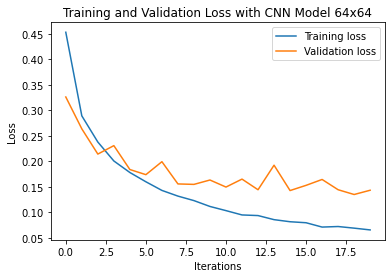

In [36]:
#Plotting for Loss
plt.plot(train_losses_cnn_1, label='Training loss')
plt.plot(val_losses_cnn_1, label='Validation loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.ylim()
plt.title('Training and Validation Loss with CNN Model 64x64')
# plt.savefig('plots/Training Validation Loss with CNN from scratch.png')
plt.show()

In [22]:
CNN_model_1_64 = CNN_model_1()
CNN_model_1_64.to(device)
CNN_model_1_64.load_state_dict(torch.load('CNN_Model_1_64'))

<All keys matched successfully>

In [24]:
#Function for Testing our Model 
def test(loaders, model, criterion, device):
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU or CPU
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())
            
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: ',(
        100. * correct / total, correct, total))
    
    return y, y_hat

In [25]:
#Function for obtaining training Accuracy
def test_for_trainacc(loaders, model, criterion, device):
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        # move to GPU or CPU
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())
            
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Train Loss: {:.6f}\n'.format(test_loss))

    print('\nTrain Accuracy: ',(
        100. * correct / total, correct, total))
    
    return y, y_hat

In [42]:
y, y_hat = test(dataloaders_2, CNN_model_1_64, criterion,device)

Test Loss: 0.134399


Test Accuracy:  (95.0818274803955, 22310.0, 23464.0)


In [39]:
y, y_hat = test_for_trainacc(dataloaders_2, CNN_model_1_64, criterion,device)

Train Loss: 0.066001


Train Accuracy:  (97.56014821773394, 37387.0, 38322.0)


In [38]:
cm1 = confusion_matrix(y, y_hat)

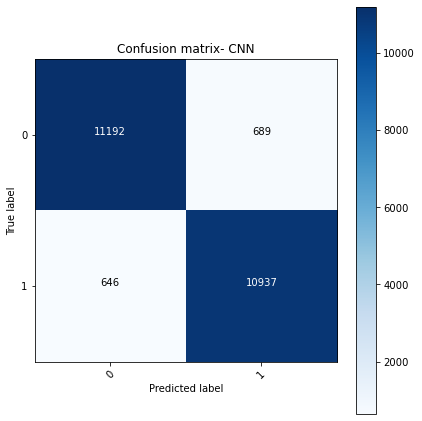

In [39]:
confusion_matrix2(cm1, classes=['0','1'],title='Confusion matrix- CNN',
                           filename='Confusion Matrix with CNN 64 from scratch', figsize=(6,6))

In [22]:
# PART 2
from torch import nn, optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)

In [23]:
CNN_model_1_64 , train_losses_cnn_1, val_losses_cnn_1 = train_model(
    train_loader=train_loader2,
    test_loader=valid_loader2,
    model=model_1,
    criterion=criterion,
    optimizer=optimizer,
    epochs=20, save_path = 'CNN_Model_1_64_SGD' 
)

Epoch: 0 	Training Loss: 0.632196 	Validation Loss: 0.570538
Saving model..
Epoch: 1 	Training Loss: 0.559110 	Validation Loss: 0.536063
Saving model..
Epoch: 2 	Training Loss: 0.485616 	Validation Loss: 0.432437
Saving model..
Epoch: 3 	Training Loss: 0.395556 	Validation Loss: 0.353143
Saving model..
Epoch: 4 	Training Loss: 0.340487 	Validation Loss: 0.339798
Saving model..
Epoch: 5 	Training Loss: 0.303132 	Validation Loss: 0.287677
Saving model..
Epoch: 6 	Training Loss: 0.277939 	Validation Loss: 0.271072
Saving model..
Epoch: 7 	Training Loss: 0.253311 	Validation Loss: 0.258878
Saving model..
Epoch: 8 	Training Loss: 0.231461 	Validation Loss: 0.214935
Saving model..
Epoch: 9 	Training Loss: 0.213444 	Validation Loss: 0.233133
Epoch: 10 	Training Loss: 0.201853 	Validation Loss: 0.203651
Saving model..
Epoch: 11 	Training Loss: 0.186483 	Validation Loss: 0.238996
Epoch: 12 	Training Loss: 0.175917 	Validation Loss: 0.182365
Saving model..
Epoch: 13 	Training Loss: 0.161960 	Val

Test Loss: 0.168858


Test Accuracy:  (93.18956699624957, 21866.0, 23464.0)
Train Loss: 0.118099


Train Accuracy:  (95.08898282970617, 36440.0, 38322.0)


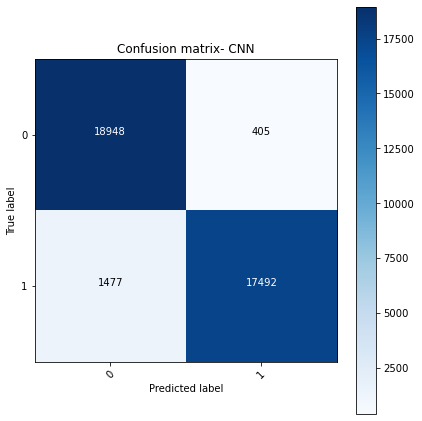

In [26]:
def test(loaders, model, criterion, device):
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU or CPU
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())
            
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: ',(
        100. * correct / total, correct, total))
    
    return y, y_hat

def test_for_trainacc(loaders, model, criterion, device):
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        # move to GPU or CPU
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())
            
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Train Loss: {:.6f}\n'.format(test_loss))

    print('\nTrain Accuracy: ',(
        100. * correct / total, correct, total))
    
    return y, y_hat

y, y_hat = test(dataloaders_2, CNN_model_1_64, criterion,device)

y, y_hat = test_for_trainacc(dataloaders_2, CNN_model_1_64, criterion,device)

cm1 = confusion_matrix(y, y_hat)

confusion_matrix2(cm1, classes=['0','1'],title='Confusion matrix- CNN',
                           filename='Confusion Matrix with CNN 64 from scratch', figsize=(6,6))

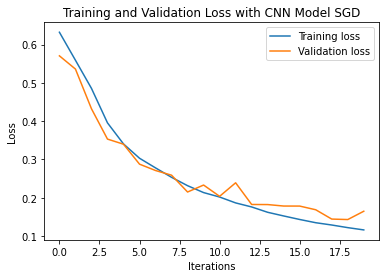

In [29]:
plt.plot(train_losses_cnn_1, label='Training loss')
plt.plot(val_losses_cnn_1, label='Validation loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.ylim()
plt.title('Training and Validation Loss with CNN Model SGD')
plt.show()